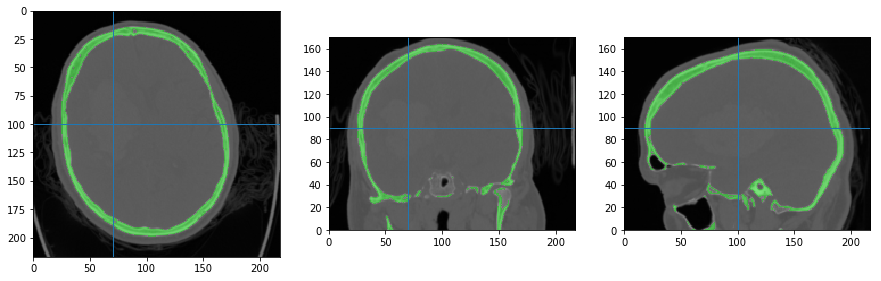

In [4]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os



from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));
    
def label_overlay(img, seg):
    minmax = sitk.MinimumMaximumImageFilter()
    minmax.Execute(img)
    low, high = minmax.GetMinimum(), minmax.GetMaximum()
    img_norm = (img - low) / (high - low)
    img_uint8 = sitk.Cast(256 * img_norm, sitk.sitkUInt8)
    return sitk.LabelOverlay(img_uint8, seg)

def display_overlay(img, seg, *args, **kwargs):
    display_image(label_overlay(img, seg), *args, **kwargs)
    
seg = (img > 500)
display_overlay(img, seg, x=70, y=100, z=90)

In [10]:
paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH2/1777243_13410770_02_140806_2233_002_ThinSliceSeq_4_0_H40s_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH4/3708063_10968221_01_310816_2010_002_Head_5_0_MPR_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH7/m_3742364_11045234_01_211016_0208_002_Head_5_0_J40s_3_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH8/3758895_11066947_01_041116_0009_007_Head_5_0_J40s_3_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH9/3764350_##_01_131116_0152_002_Head_5_0_J40s_3_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH11/3797770_23590_01_221216_0345_002_Head_5_0_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH12/3798130_43976_01_040117_2338_002_Brain_2_5_5mm_SS40_image.nii.gz',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH14/6vqQ294_CT1.nii.gz',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/ct_20215_2_image.nii.gz',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH24/ct_12715_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT4/1805902_13598258_01_100407_1814_002_ThinSliceSeq_4_0_H40s_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT5/g_3487946_10590242_01_161215_0440_002_Head_5_0_J40s_3_image.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT7/3797961_76845_02_010117_2344_002_Head_5_0_image.nii.gz',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/EDH7/3799763_93620_01_231216_1823_80256_MPR_image.nii.gz',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre/S3_Pre-op.nrrd',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Post/S3_Post-op.nrrd',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample4_Pre/S4_Pre-op.nrrd',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/ct-brain.nii.gz']

for i in range(len(paths)):
# for i in range(0,1):
    path = paths[i]
    # We convert it to `float32` for compatibility with some functions we'll use later
    img = sitk.Cast(sitk.ReadImage(path), sitk.sitkFloat32)
#     display_image(img,window=120,level=40)
    img_gauss = sitk.DiscreteGaussian(img, variance=1)
    # display_image(img_gauss,window=120,level=40)
    seg = (img > 500)
#     display_overlay(img, seg)
    seg_array = sitk.GetArrayFromImage(seg)
    mp = sitk.ReadImage(os.path.split(path)[0] + '/Midplane_Q.nii.gz')
    mp_array = sitk.GetArrayFromImage(mp)
    Skull_contour = np.multiply(mp_array,seg_array)
    Skull_contour1 = sitk.GetImageFromArray(Skull_contour)
    Skull_contour1.CopyInformation(img)
    sitk.WriteImage(Skull_contour1, os.path.split(path)[0] + '/Skull_contour.nii.gz')